## PyTorch Classification with CIFAR10
#### Landon Buell - July 2023

In [1]:
import os

import torch
import torchvision

In [40]:
# Construct the Transform process for when Images are Loaded

imageNorms = (0.5,0.5,0.5)
imageLoaderTransforms = torchvision.transforms.Compose([ torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Normalize(imageNorms,imageNorms)])

datasetRoot = "C:\\Users\\lando\\Documents\\datasets"
batchSize = 8

In [41]:
# Build the train set
trainDataset = torchvision.datasets.CIFAR10(root=datasetRoot,train=True,download=True,transform=imageLoaderTransforms)
trainLoader = torch.utils.data.DataLoader(trainDataset,batch_size=batchSize,shuffle=True)

Files already downloaded and verified


In [42]:
# Build the Test set
testDataset = torchvision.datasets.CIFAR10(root=datasetRoot,train=False,download=True,transform=imageLoaderTransforms)
testLoader = torch.utils.data.DataLoader(testDataset,batch_size=batchSize,shuffle=True)

Files already downloaded and verified


In [43]:
# Define the names of each class
CLASS_NAMES = ["Plane","Car","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]

In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
def display(image):
    """ Show an Image """
    image = (image / 2) + 0.5
    numpyImage = image.numpy()
    plt.imshow(np.transpose(numpyImage,(1,2,0)))
    plt.show()

In [46]:
# Get some random training images
trainDataIter = iter(trainLoader)
images,labels = next(trainDataIter)

In [47]:
images.shape

torch.Size([8, 3, 32, 32])

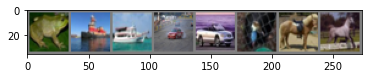

Frog Ship Ship Car Car Bird Horse Horse


In [48]:
display(torchvision.utils.make_grid(images))
print(" ".join(["{0}".format(CLASS_NAMES[labels[x]]) for x in range(batchSize)]))

In [127]:
# Define a Convolutional Neural Network

class MyNet(torch.nn.Module):
    """ Basic CNN """
    
    def __init__(self,numClasses: int):
        """ Constructor """
        super().__init__()
        self._numClasses = numClasses
        self._conv1A = torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),stride=(1,1))
        self._conv1B = torch.nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),stride=(1,1))
        
        self._conv2A = torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),stride=(1,1))
        self._conv2B = torch.nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),stride=(1,1))
        
        self._pool = torch.nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
        self._dense1 = torch.nn.Linear(in_features=32*5*5,out_features=128)
        self._dense2 = torch.nn.Linear(in_features=128,out_features=64)
        self._dense3 = torch.nn.Linear(in_features=64,out_features=self._numClasses)
        
    def __del__(self):
        """ Destructor """
        pass
    
    def forward(self,x):
        """ Define forward pass """
        x = torch.nn.functional.relu( self._conv1A(x) ) 
        x = torch.nn.functional.relu( self._conv1B(x) ) 
        x = self._pool( x )
        
        x = torch.nn.functional.relu( self._conv2A(x) ) 
        x = torch.nn.functional.relu( self._conv2B(x) ) 
        x = self._pool( x )

        x = torch.flatten(x,start_dim=1,end_dim=-1)
        x = torch.nn.functional.relu( self._dense1(x) )
        x = torch.nn.functional.relu( self._dense2(x) )
        x = torch.nn.functional.softmax( self._dense3(x), dim = 1)
        return x
              

In [128]:
# Create an instance
myNet = MyNet(len(CLASS_NAMES))

In [130]:
# print out the shape of each param
for item in myNet.parameters():
    print(item.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([128, 800])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [131]:
# Define a Loss & Objective
objective = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(myNet.parameters(),lr=0.01,momentum=0.9)

In [149]:
# Training Loop for the Network

def train():
    """ Train the Model """
    numEpochs = 2
    losses = []
    runningLoss = 0.0
    
    for epoch in range(numEpochs):
        
        for ii,data in enumerate(trainLoader,0):
            

            # Get the inputs & zero the optimizer
            inputs,labels = data
            optimizer.zero_grad()

            # Forward Pass + Compute Loss
            outputs = myNet(inputs)
            loss = objective(outputs,labels)

            # Back Propagate + Step
            loss.backward()
            optimizer.step()

            # Store loss
            runningLoss += loss.item() * len(labels)
            losses.append(runningLoss / len(trainDataset))
            
            # Message - every 100 batches
            if (ii % 1000 == 0):
                msg = "Epoch: {0:<4} Batch {1:<4}".format(epoch,ii)
                print(msg)
            
    msg = "Finished Training"
    print(msg)
    return losses


In [150]:
# Execute the training Loop
lossHistory = train()

Epoch: 0    Batch 0   
Epoch: 0    Batch 1000
Epoch: 0    Batch 2000
Epoch: 0    Batch 3000
Epoch: 0    Batch 4000
Epoch: 0    Batch 5000
Epoch: 0    Batch 6000
Epoch: 1    Batch 0   
Epoch: 1    Batch 1000
Epoch: 1    Batch 2000
Epoch: 1    Batch 3000
Epoch: 1    Batch 4000
Epoch: 1    Batch 5000
Epoch: 1    Batch 6000
Finished Training


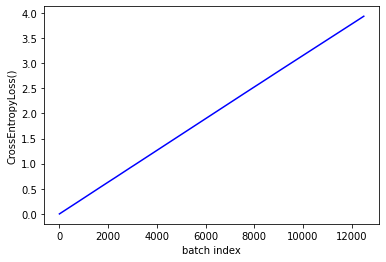

In [151]:
plt.plot(lossHistory,color="blue")
plt.xlabel("batch index")
plt.ylabel(objective)
plt.show()

In [137]:
# Save the Trained Model to Disk
savePath = os.path.join("cifar10.pth")
torch.save(myNet.state_dict(),savePath)

In [138]:
# Now, test the model against the test data set
testDataIter = iter(testLoader)
images,labels = next(testDataIter)

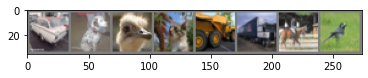

Car Dog Bird Cat Truck Truck Horse Bird


In [139]:
display(torchvision.utils.make_grid(images))
print(" ".join(["{0}".format(CLASS_NAMES[labels[x]]) for x in range(batchSize)]))

In [140]:
myNewNet = MyNet(len(CLASS_NAMES))
myNewNet.load_state_dict(torch.load(savePath))

<All keys matched successfully>

In [141]:
outputs = myNewNet(images)

In [142]:
values,predictions = torch.max(outputs,dim=1)

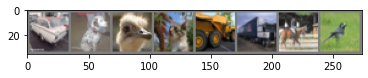

Car      Dog      Bird     Cat      Truck    Truck    Horse    Bird    
Ship     Dog      Bird     Horse    Cat      Truck    Deer     Bird    


In [143]:
# Print out the predictions vs. the truth
display(torchvision.utils.make_grid(images))
print(" ".join(["{0:<8}".format(CLASS_NAMES[labels[x]]) for x in range(batchSize)]))
print(" ".join(["{0:<8}".format(CLASS_NAMES[predictions[x]]) for x in range(batchSize)]))

In [144]:
# Compare performance across the ful dataset
correct = 0
total = 0

# Since we're not training, no need to calculate the graidient
with torch.no_grad():
    for data in testLoader:
        images,labels = data
        
        outputs = myNewNet(images)
        vals,predictions = torch.max(outputs.data,dim=1)
        
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

In [145]:
# Print the accuracy
accuracyScore = (correct / total) * 100.0
msg = "Correctly classified {0} / {1} items for a {2}% accurary rate".format(correct,total,accuracyScore)
print(msg)

Correctly classified 4455 / 10000 items for a 44.55% accurary rate


In [146]:
# Now Compare performance for each class
correct = [0] * len(CLASS_NAMES)
total = [0] * len(CLASS_NAMES)

# No gradients
with torch.no_grad():
    for data in testLoader:
        images,labels = data
        outputs = myNewNet(images)
        values,predictions = torch.max(outputs.data,dim=1)
        
        for label,pred in zip(labels,predictions):   
            if (label == pred):
                correct[label] += 1
            total[label] += 1
            

In [147]:
# Print the accuracy per class
for ii in range(len(CLASS_NAMES)):
    accuracyScore = (correct[ii] / total[ii]) * 100.0
    msg = "Class: {0:<8} - {1}/{2} for {3}% accuracy".format(
        CLASS_NAMES[ii],correct[ii],total[ii],accuracyScore)
    print(msg)

Class: Plane    - 461/1000 for 46.1% accuracy
Class: Car      - 536/1000 for 53.6% accuracy
Class: Bird     - 466/1000 for 46.6% accuracy
Class: Cat      - 305/1000 for 30.5% accuracy
Class: Deer     - 298/1000 for 29.799999999999997% accuracy
Class: Dog      - 283/1000 for 28.299999999999997% accuracy
Class: Frog     - 679/1000 for 67.9% accuracy
Class: Horse    - 388/1000 for 38.800000000000004% accuracy
Class: Ship     - 654/1000 for 65.4% accuracy
Class: Truck    - 385/1000 for 38.5% accuracy
